In [1]:
#Import Libraries
import pandas as pd
import string
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series, DataFrame
from matplotlib import rcParams
import pandas as pd
from collections import Counter
from itertools import chain
#from wordcloud import WordCloud, STOPWORDS
import re
import warnings
warnings.filterwarnings("ignore")
import collections
import os
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
rcParams['figure.figsize'] = 20,12
ps = PorterStemmer()
nltk.download('punkt')
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xaris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xaris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#load the data
reviews = pd.read_csv(r"reviews_all_new.csv")
#drop unwanted column
reviews.drop(columns = ["Unnamed: 0"], inplace = True)
stop1 = ['food','good','nice','price','place','servic','restaur','visit','friendli','thessaloniki','order','great','dish','recommend','amaz','one','realli','us','serv','staff','qualiti','’','time', 'tri', 'experi', 'come', 'small', 'local', 'even', 'excel', 'reason', 'atmospher', 'best', 'love', 'enjoy', 'would', 'greek', 'well', 'also', 'fresh', 'back', 'like', 'tast', 'wine', 'definit', 'tabl', 'offer', 'menu', 'salad', 'drink', 'waiter', 'tradit', 'tasti', 'delici', 'day', 'peopl', 'go', 'meal', 'fish', 'dinner', 'eat', 'cook', 'portion', 'look', 'meat', 'citi', 'everyth', 'music', 'locat', 'lunch','town', 'warm', 'year', 'outsid', 'street', 'chicken', 'coffe', 'night', 'perfect', 'much', 'want', 'view', 'got', 'plate', 'littl', 'sea', 'expect', 'owner', 'ok', 'make', 'way', 'next', 'sit', 'wait', 'pizza', 'friend', 'cuisin', 'high', 'lot', 'differ', 'kind', 'noth', 'special', 'choic', 'decor', 'live', 'greec', 'alway', 'center', 'better', 'bread', 'ask', 'help', 'dont', 'get', 'mani', 'top', 'fantast', 'thing', 'say', 'two', 'first', 'didnt', 'busi', 'went', 'came', 'cours', 'though', 'polit', 'find', 'fast', 'end', 'grill', 'take', 'found', 'ever', 'quit', 'euro', 'wonder', 'everi', 'starter', 'bar', 'area', 'main', '2', 'full', 'hous', 'highli', 'could', 'burger', 'chees', 'made', 'big', 'valu', 'must', 'select', 'smoke', 'beauti', 'last', 'around', 'someth', 'varieti', 'money', 'feel', 'fri', 'beer', 'seafood', 'bit', 'insid', 'sure', 'worth', 'expens', 'disappoint', 'need', 'ate', 'famili', 'dessert','\"','”','“']

# Preprocessing 

In [3]:
# Remove punctuation
reviews['Review'] = reviews['Review'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))
#Lower case everything
reviews['Review'] = reviews['Review'].str.lower()
reviews['Review_Distribution'] = reviews['Review_Distribution'].str.lower()
#Tokenize the reviews
reviews['Review'] = reviews.apply(lambda row: nltk.word_tokenize(row['Review']), axis=1)
#Remove stopwords
reviews['Review'] = reviews['Review'].apply(lambda x: [item for item in x if item not in stop])
#Stemming
reviews['Review'] = reviews['Review'].apply(lambda x: [ps.stem(y) for y in x])

#get the month
reviews['Rating_Month'] = reviews["Rating_date"].str.split(" ").str[0]
#get the year
reviews['Rating_Year'] = reviews["Rating_date"].str.split(",").str[1]
reviews['Rating_Year'] = reviews["Rating_Year"].str.replace(" ","")

#Create a new dataframe that contains the reviews and remove the extra stopwords
reviews_lda = reviews.copy()
reviews_lda['Review'] = reviews_lda['Review'].apply(lambda x: [item for item in x if item not in stop1])

## Polarity Score

In [40]:
#Calculate the polarity of a text
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#Unify a list of words and separate them by whitespace
def list_to_txt(item):
    str =' '.join(item)
    return str

# User Profiling

In [60]:
#Drop rows, where there is no information about age, gender or location
reviews['Age_Gender_Location'].dropna(inplace = True)

#Extract age and gender for each reviewer
reviews['Age'] = reviews['Age_Gender_Location'].str.extract(r'(\d+-\d+)')
reviews['Gender'] = reviews['Age_Gender_Location'].str.extract(r'(\n?\bwoman|\n?\bman)')
reviews['Gender'] = reviews['Gender'].str.replace("\n",'')

In [61]:
#Calculate the percentage of women/men and each age group
age_percentage = ((reviews['Age'].value_counts())/reviews['Age'].value_counts().sum())*100
display(age_percentage)

gender_percentage = ((reviews['Gender'].value_counts())/reviews['Gender'].value_counts().sum())*100
display(gender_percentage)

35-49    45.608928
25-34    25.788452
50-64    24.502669
18-24     3.881611
13-17     0.218341
Name: Age, dtype: float64

man      64.919837
woman    35.080163
Name: Gender, dtype: float64

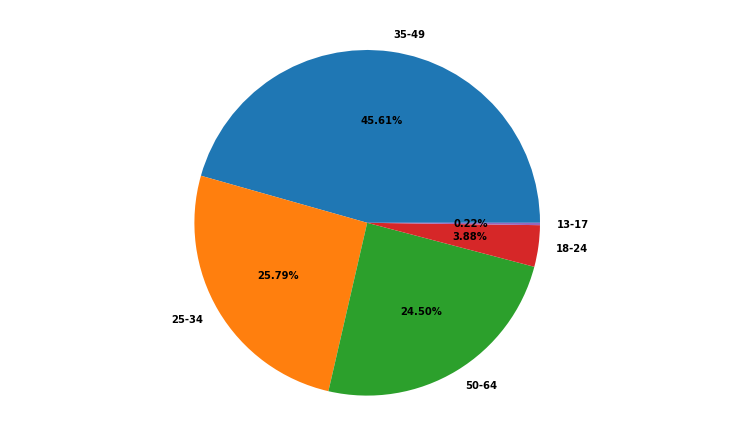

In [63]:
#Display the percentages of each age group in pie charts
fig = plt.figure()
ax = fig.add_axes([0,0,0.5,0.5])
ax.axis('equal')
langs = ['35-49', '25-34', '50-64', '18-24', '13-17']
ax.pie(age_percentage, labels = langs,autopct='%1.2f%%')
plt.show()

In [64]:
#Import some extra libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from textblob import TextBlob
import emoji

In [65]:
#Function that is used to extract emojis from texts
def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.UNICODE_EMOJI['en'])

#Function to join tokens in one string
def list_to_txt(item):
    str =' '.join(item)
    return str

#Function to extract polarity from text using the library "TextBlob"
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

## Gender Prediction

In [66]:
#Create a copy of the dataframe in order that we can use it to fit a model that predicts the gender of the reviewer
reviews_model = reviews.copy()

#Keep the columns that will be used to predict the gender
reviews_model.drop(reviews_model.columns.difference(['Review', 'Gender', 'Review_Distribution', 'Score']), 1, inplace = True)
reviews_model['Review'] = list(map(list_to_txt, reviews_model["Review"]))

#Extract polarity for each review in order to use it as a feature in the model
polarities = list(map(getPolarity, reviews_model['Review']))
polarities_df = pd.DataFrame(polarities)
reviews_model = pd.concat([reviews_model, polarities_df], axis = 1)
reviews_model.rename(columns = {0:"Polarity"}, inplace = True)

In [67]:
#In order to use the Review Distribution in the model, we extract the number of "excellent", "very good", "good", 
#"poor" and "terrible" reviews of each reviewer, if this information is available, and create 5 new features.
ex = []
vg = []
av = []
pr = []
tr = []
 
for i in range(len(reviews_model)):
    if reviews_model['Review_Distribution'][i] is not np.nan:
        ex.append(re.findall(r'\d+',reviews_model['Review_Distribution'][i])[0])
        vg.append(re.findall(r'\d+',reviews_model['Review_Distribution'][i])[1])
        av.append(re.findall(r'\d+',reviews_model['Review_Distribution'][i])[2])
        pr.append(re.findall(r'\d+',reviews_model['Review_Distribution'][i])[3])
        tr.append(re.findall(r'\d+',reviews_model['Review_Distribution'][i])[4])
    else:
        ex.append(np.nan)
        vg.append(np.nan)
        av.append(np.nan)
        pr.append(np.nan)
        tr.append(np.nan)
        
reviews_model['Excellent'] = pd.DataFrame(ex)
reviews_model['Very_Good'] = pd.DataFrame(vg)
reviews_model['Average'] = pd.DataFrame(av)
reviews_model['Poor'] = pd.DataFrame(pr)
reviews_model['Terrible'] = pd.DataFrame(tr)

In [68]:
#Split the dataframe based on whether there is information about gender or not
reviews_without_gender = reviews_model[reviews_model['Gender'].isna()]
reviews_without_gender.reset_index(inplace = True, drop = True)

reviews_model.dropna(inplace = True, subset = ['Gender'])
reviews_model.reset_index(inplace = True, drop = True)

In [69]:
print(len(reviews_without_gender))
print(len(reviews_model))

10194
4179


In [70]:
#Display the emojis that are used in the reviews
reviews_with_emojis = reviews_model["Review"].apply(extract_emojis)
reviews_with_emojis.value_counts()

          4162
❤            4
😉            3
👍👍👍😛😛😛       1
😀            1
😊            1
🍟            1
🙏🏻😊🍺❤        1
©            1
💙👌           1
🍕            1
👍😊           1
🍷💕           1
Name: Review, dtype: int64

In [71]:
#Encode the target label to use it in the model
le = LabelEncoder()
reviews_model['Gender'] = le.fit_transform(reviews_model['Gender'])
x = reviews_model[['Review', 'Score', 'Polarity', 'Excellent', 'Very_Good', 'Average', 'Poor', 'Terrible']]
y = reviews_model['Gender']

In [72]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer

#Split data in training and test set 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
X_train.reset_index(inplace = True, drop = True)
X_test.reset_index(inplace = True, drop = True)
y_train.reset_index(inplace = True, drop = True)
y_test.reset_index(inplace = True, drop = True)

#Initialize imputer
imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')

X_train_dist = X_train[['Excellent', 'Very_Good', 'Average', 'Poor', 'Terrible']]
X_train_dist = pd.DataFrame(imp_mean.fit_transform(X_train_dist))
X_train_dist = X_train_dist.rename(columns={0: 'Excellent', 1: 'Very_Good', 2: 'Average', 3: 'Poor', 4: 'Terrible'})
X_train = pd.concat([X_train[['Review', 'Score','Polarity']], X_train_dist], axis=1)

X_test_dist = X_test[['Excellent', 'Very_Good', 'Average', 'Poor', 'Terrible']]
X_test_dist = pd.DataFrame(imp_mean.transform(X_test_dist))
X_test_dist = X_test_dist.rename(columns={0: 'Excellent', 1: 'Very_Good', 2: 'Average', 3: 'Poor', 4: 'Terrible'})
X_test = pd.concat([X_test[['Review', 'Score','Polarity']], X_test_dist], axis=1)

#Split training data into training and validation set in order to select the classification algorithm that achieves 
#the largest accuracy
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

names = ["Random Forest", "Logistic Regression", "AdaBoost"]
classifiers = [RandomForestClassifier(n_estimators = 40), LogisticRegression(random_state = 0, max_iter=2000), AdaBoostClassifier(n_estimators = 30)]
#Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features = 50)

#Construct the column transfomer
column_transformer = ColumnTransformer(
    [('tfidf1', vectorizer, 'Review')],
    remainder = 'passthrough')

for name, model in zip(names, classifiers):
    # fit the model
    print(name)
    pipe = Pipeline([('tfidf', column_transformer),
                     ('classify', model)])
    pipe.fit(X_train2, y_train2)
    y_pred = pipe.predict(X_val)
    print(classification_report(y_val, y_pred))

Random Forest
              precision    recall  f1-score   support

           0       0.68      0.87      0.76       308
           1       0.47      0.23      0.31       163

    accuracy                           0.65       471
   macro avg       0.58      0.55      0.53       471
weighted avg       0.61      0.65      0.60       471

Logistic Regression
              precision    recall  f1-score   support

           0       0.67      0.86      0.75       308
           1       0.42      0.20      0.27       163

    accuracy                           0.63       471
   macro avg       0.54      0.53      0.51       471
weighted avg       0.58      0.63      0.58       471

AdaBoost
              precision    recall  f1-score   support

           0       0.68      0.80      0.74       308
           1       0.44      0.29      0.35       163

    accuracy                           0.63       471
   macro avg       0.56      0.55      0.55       471
weighted avg       0.60      0.

In [73]:
#Fit a Random Forest classifier using all of the training data and test it in test data
pipe = Pipeline([('tfidf', column_transformer),
                 ('classify',  RandomForestClassifier(n_estimators = 40))])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.90      0.79       699
           1       0.55      0.25      0.34       346

    accuracy                           0.68      1045
   macro avg       0.63      0.57      0.57      1045
weighted avg       0.66      0.68      0.64      1045



In [74]:
#Use the fitted model to predict the gender for the reviewers that we don't know
x_without_gender = reviews_without_gender[['Review', 'Score', 'Polarity', 'Excellent', 'Very_Good', 'Average', 'Poor', 'Terrible']]

#Use the fitted imputer in order to complete the missing values of the review distribution
x_without_gender_dist = x_without_gender[['Excellent', 'Very_Good', 'Average', 'Poor', 'Terrible']]
x_without_gender_dist = pd.DataFrame(imp_mean.transform(x_without_gender_dist))
x_without_gender_dist = x_without_gender_dist.rename(columns={0: 'Excellent', 1: 'Very_Good', 2: 'Average', 3: 'Poor', 4: 'Terrible'})
x_without_gender = pd.concat([x_without_gender[['Review', 'Score', 'Polarity']], x_without_gender_dist], axis=1)

#Predict the gender for the unknown data
y_gender = pipe.predict(x_without_gender)
y_gender_df = pd.DataFrame(y_gender)
y_gender_df = y_gender_df.rename(columns={0: 'Gender'})

In [75]:
reviews_gender1 = pd.concat([X_train, y_train], axis = 1)
reviews_gender2 = pd.concat([X_test, y_test], axis = 1)
reviews_gender3 = pd.concat([x_without_gender, y_gender_df], axis = 1)
reviews_gender_all = pd.concat([reviews_gender1, reviews_gender2, reviews_gender3], axis=0, ignore_index = True)
reviews_gender_all

,Review,Score,Polarity,Excellent,Very_Good,Average,Poor,Terrible,Gender
0,gianni place tri best mpougatsa thessaloniki n...,50,0.383333,32.000000,14.000000,6.000000,1.000000,0.000000,0
1,often lunch work feel like eat home comfort fo...,50,0.600000,5.000000,0.000000,2.000000,1.000000,0.000000,1
2,took even diner restaur last night stay thessa...,50,0.250000,34.000000,43.000000,10.000000,0.000000,0.000000,0
3,ive sever time say get betterth bread serv unb...,50,0.450000,53.000000,21.000000,5.000000,6.000000,4.000000,0
4,central locat dish nice went twice compar food...,40,0.700000,31.000000,183.000000,146.000000,24.000000,11.000000,0
...,...,...,...,...,...,...,...,...,...
14368,slept close restaur went small dinner waiter o...,50,0.600000,64.203291,58.078412,22.776057,5.813166,2.445628,0
14369,good restaur nice atmospher interieur beauti n...,50,0.266667,7.000000,0.000000,0.000000,0.000000,0.000000,0
14370,food meat ball fri potato risotto squid shrimp...,50,0.312500,64.203291,58.078412,22.776057,5.813166,2.445628,0
14371,best coffe trip frapp frothi coffe bitter even...,50,0.544444,4.000000,0.000000,0.000000,0.000000,0.000000,0


0    79.078828
1    20.921172
Name: Gender, dtype: float64

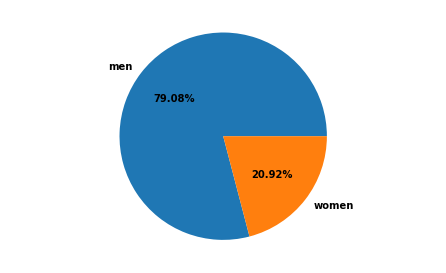

In [76]:
#Display the percentages of men/women in pie charts
gender_percentage = ((reviews_gender_all['Gender'].value_counts())/reviews_gender_all['Gender'].value_counts().sum())*100
display(gender_percentage)

fig = plt.figure()
ax = fig.add_axes([0, 0, 0.3, 0.3])
ax.axis('equal')
langs = ["men", "women"]
ax.pie(gender_percentage, labels = langs, autopct='%1.2f%%')
plt.show()

In [77]:
#Sentiment/polarity in a bar chart
words_per_gender = reviews_gender_all.drop(reviews_gender_all.columns.difference(['Review', 'Gender']), 1)
words_per_gender.reset_index(inplace = True, drop = True)

#Group reviews based on gender
test = words_per_gender.groupby(['Gender'], as_index = False).agg({'Review': '  '.join})
#Remove common words like we did in the LDA task
test['Review'] = test['Review'].str.split(' ').apply(lambda x: ' '.join(k for k in x if k not in stop1))
test

,Gender,Review
0,0,gianni mpougatsa breakfast energi walk sweet l...
1,1,often work home comfort everyday popular inde ...


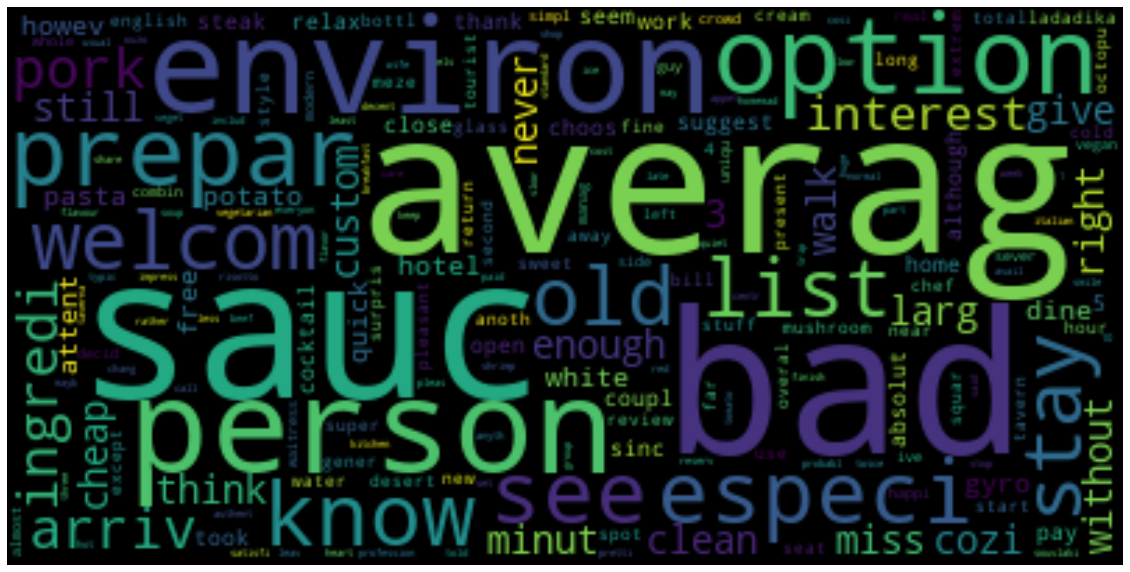

In [78]:
#Keep only men's reviews
words = pd.DataFrame(test['Review'][0].split(" "))
words[0] = words[0].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))
values = words[0].value_counts(dropna=False).keys().tolist()
counts = words[0].value_counts(dropna=False).tolist()
value_dict = dict(zip(values, counts))
unigrams = pd.DataFrame(value_dict.items(), columns=['word', 'frequency'])
unigrams.sort_values(by = ['frequency'],ascending=False)
tuples = [tuple(x) for x in unigrams.values]

#create wordcloud
wordcloud = WordCloud().generate_from_frequencies(dict(tuples))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()  

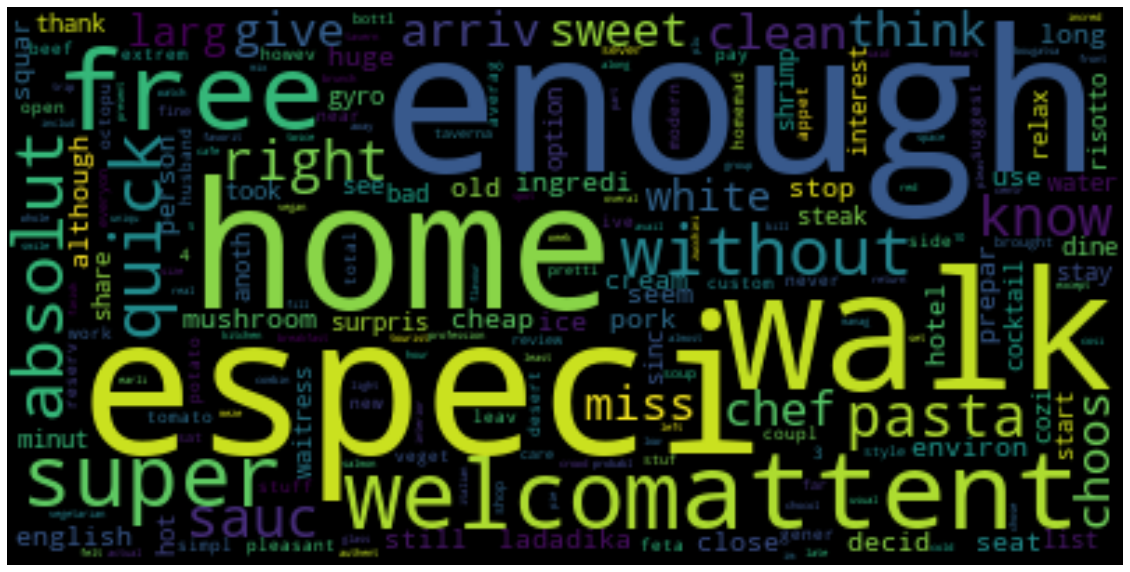

In [79]:
#Keep women's reviews
words = pd.DataFrame(test["Review"][1].split(" "))
words[0] = words[0].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))
values = words[0].value_counts(dropna=False).keys().tolist()
counts = words[0].value_counts(dropna=False).tolist()
value_dict = dict(zip(values, counts))
unigrams = pd.DataFrame(value_dict.items(), columns=['word', 'frequency'])
unigrams.sort_values(by = ['frequency'],ascending=False)
tuples = [tuple(x) for x in unigrams.values]

#create wordcloud
wordcloud = WordCloud().generate_from_frequencies(dict(tuples))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()          

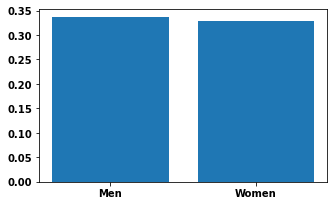

In [80]:
#Calculate the mean polarity of each gender and create a bar chart
rev = reviews_gender_all.drop(reviews_gender_all.columns.difference(['Polarity', 'Gender']), 1)
polarity_per_gender = rev.groupby(['Gender']).mean()['Polarity']

fig = plt.figure()
ax = fig.add_axes([0,0,0.2,0.2])
langs = ['Men', 'Women']
ax.bar(langs, polarity_per_gender)
plt.show()

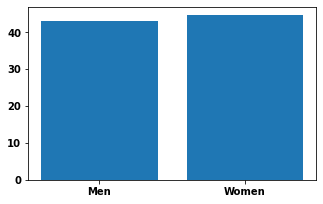

In [81]:
#Calculate the mean score of each gender and create a bar chart
rev_score = reviews_gender_all.drop(reviews_gender_all.columns.difference(['Score', 'Gender']), 1)
score_per_gender = rev_score.groupby(['Gender']).mean()['Score']

fig = plt.figure()
ax = fig.add_axes([0,0,0.2,0.2])
langs = ['Men', 'Women']
ax.bar(langs, score_per_gender)
plt.show()

In [82]:
score_per_gender

Gender
0    43.122471
1    44.652478
Name: Score, dtype: float64

<AxesSubplot:title={'center':'Polarity'}, xlabel='Gender'>

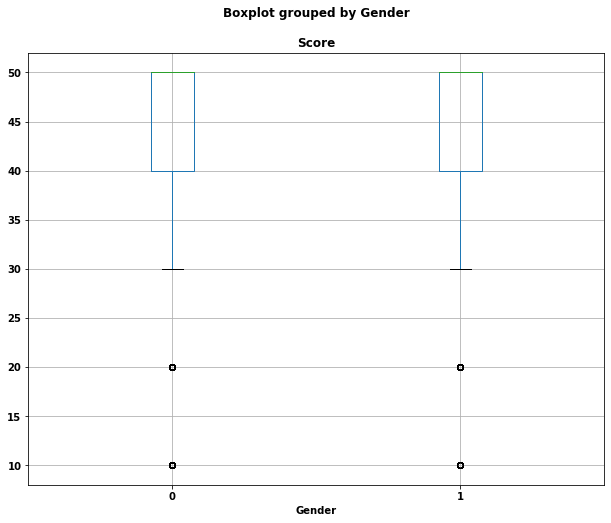

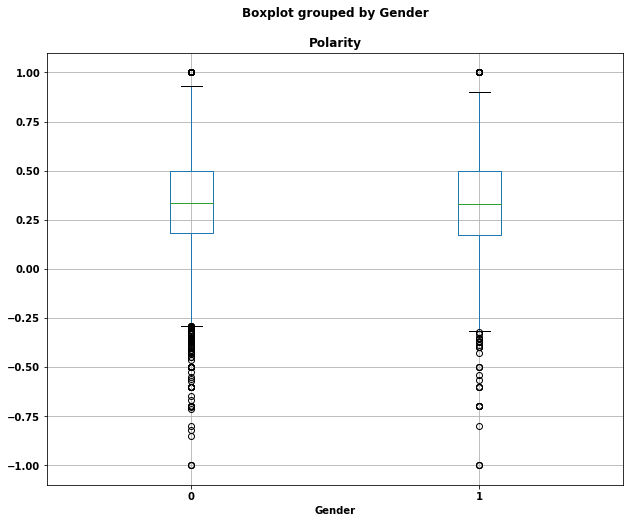

In [83]:
#Create box plots of score and polarity for each gender
rev_score.boxplot(column='Score', by='Gender', fontsize=10, figsize=(10,8))
rev.boxplot(column='Polarity', by='Gender', fontsize=10, figsize=(10,8))

## Age Group Prediction

In [84]:
#Create a copy of the dataframe in order that we can use it to fit a model that predicts the age group of the reviewer
reviews_age = reviews.copy()

#Keep the columns that will be used to predict the gender
reviews_age.drop(reviews_age.columns.difference(['Review', 'Age', 'Review_Distribution', 'Score']), 1, inplace = True)
reviews_age['Review'] = list(map(list_to_txt, reviews_age["Review"]))

#Extract polarity for each review in order to use it as a feature in the model
polarities_age = list(map(getPolarity, reviews_age['Review']))
polarities_df = pd.DataFrame(polarities_age)
reviews_age = pd.concat([reviews_age, polarities_df], axis = 1)
reviews_age.rename(columns = {0:"Polarity"}, inplace = True)

In [85]:
#In order to use the Review Distribution in the model, we extract the number of "excellent", "very good", "good", 
#"poor" and "terrible" reviews of each reviewer, if this information is available, and create 5 new features.
ex = []
vg = []
av = []
pr = []
tr = []
 
for i in range(len(reviews_model)):
    if reviews_age['Review_Distribution'][i] is not np.nan:
        ex.append(re.findall(r'\d+',reviews_age['Review_Distribution'][i])[0])
        vg.append(re.findall(r'\d+',reviews_age['Review_Distribution'][i])[1])
        av.append(re.findall(r'\d+',reviews_age['Review_Distribution'][i])[2])
        pr.append(re.findall(r'\d+',reviews_age['Review_Distribution'][i])[3])
        tr.append(re.findall(r'\d+',reviews_age['Review_Distribution'][i])[4])
    else:
        ex.append(np.nan)
        vg.append(np.nan)
        av.append(np.nan)
        pr.append(np.nan)
        tr.append(np.nan)
        
reviews_age['Excellent'] = pd.DataFrame(ex)
reviews_age['Very_Good'] = pd.DataFrame(vg)
reviews_age['Average'] = pd.DataFrame(av)
reviews_age['Poor'] = pd.DataFrame(pr)
reviews_age['Terrible'] = pd.DataFrame(tr)

In [86]:
#Split the dataframe based on whether there is information about age group or not
reviews_without_age = reviews_age[reviews_age['Age'].isna()]
reviews_without_age.reset_index(inplace = True, drop = True)

reviews_age.dropna(inplace = True, subset = ['Age'])
reviews_age.reset_index(inplace = True, drop = True)

In [87]:
print(len(reviews_without_age))
print(len(reviews_age))

10251
4122


In [88]:
#Encode the target label to use it in the model
le = LabelEncoder()
reviews_age['Age'] = le.fit_transform(reviews_age['Age'])
x = reviews_age[['Review', 'Score', 'Polarity', 'Excellent', 'Very_Good', 'Average', 'Poor', 'Terrible']]
y = reviews_age['Age']

In [89]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer

#Split data in training and test set 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
X_train.reset_index(inplace = True, drop = True)
X_test.reset_index(inplace = True, drop = True)
y_train.reset_index(inplace = True, drop = True)
y_test.reset_index(inplace = True, drop = True)

#Initialize imputer
imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')

X_train_dist = X_train[['Excellent', 'Very_Good', 'Average', 'Poor', 'Terrible']]
X_train_dist = pd.DataFrame(imp_mean.fit_transform(X_train_dist))
X_train_dist = X_train_dist.rename(columns={0: 'Excellent', 1: 'Very_Good', 2: 'Average', 3: 'Poor', 4: 'Terrible'})
X_train = pd.concat([X_train[['Review', 'Score','Polarity']], X_train_dist], axis=1)

X_test_dist = X_test[['Excellent', 'Very_Good', 'Average', 'Poor', 'Terrible']]
X_test_dist = pd.DataFrame(imp_mean.transform(X_test_dist))
X_test_dist = X_test_dist.rename(columns={0: 'Excellent', 1: 'Very_Good', 2: 'Average', 3: 'Poor', 4: 'Terrible'})
X_test = pd.concat([X_test[['Review', 'Score','Polarity']], X_test_dist], axis=1)

#Split training data into training and validation set in order to select the classification algorithm that achieves 
#the largest accuracy
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

names = ["Random Forest", "Logistic Regression", "AdaBoost"]
classifiers = [RandomForestClassifier(n_estimators = 40), LogisticRegression(random_state = 0, max_iter=5000), AdaBoostClassifier(n_estimators = 30)]
#Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features = 50)

#Construct the column transfomer
column_transformer = ColumnTransformer(
    [('tfidf1', vectorizer, 'Review')],
    remainder = 'passthrough')

for name, model in zip(names, classifiers):
    # fit the model
    print(name)
    pipe = Pipeline([('tfidf', column_transformer),
                     ('classify', model)])
    pipe.fit(X_train2, y_train2)
    y_pred = pipe.predict(X_val)
    print(classification_report(y_val, y_pred, zero_division = 1))

Random Forest
              precision    recall  f1-score   support

           1       1.00      0.00      0.00        20
           2       0.30      0.18      0.23       130
           3       0.47      0.76      0.58       211
           4       0.52      0.21      0.30       103

    accuracy                           0.45       464
   macro avg       0.57      0.29      0.28       464
weighted avg       0.46      0.45      0.40       464

Logistic Regression
              precision    recall  f1-score   support

           1       1.00      0.00      0.00        20
           2       0.38      0.16      0.23       130
           3       0.48      0.81      0.60       211
           4       0.49      0.24      0.32       103

    accuracy                           0.47       464
   macro avg       0.59      0.30      0.29       464
weighted avg       0.47      0.47      0.41       464

AdaBoost
              precision    recall  f1-score   support

           0       0.00      1.0

In [90]:
pipe = Pipeline([('tfidf', column_transformer),
                 ('classify',  LogisticRegression(random_state = 0, max_iter=5000))])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred, zero_division = 1))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00         3
           1       1.00      0.00      0.00        43
           2       0.42      0.14      0.21       272
           3       0.49      0.83      0.62       483
           4       0.33      0.18      0.23       230

    accuracy                           0.47      1031
   macro avg       0.65      0.23      0.21      1031
weighted avg       0.46      0.47      0.40      1031



In [91]:
#Use the fitted model to predict the gender for the reviewers that we don't know
x_without_age = reviews_without_age[['Review', 'Score', 'Polarity', 'Excellent', 'Very_Good', 'Average', 'Poor', 'Terrible']]

x_without_age_dist = x_without_age[['Excellent', 'Very_Good', 'Average', 'Poor', 'Terrible']]
x_without_age_dist = pd.DataFrame(imp_mean.transform(x_without_age_dist))
x_without_age_dist = x_without_age_dist.rename(columns={0: 'Excellent', 1: 'Very_Good', 2: 'Average', 3: 'Poor', 4: 'Terrible'})
x_without_age = pd.concat([x_without_age[['Review', 'Score', 'Polarity']], x_without_age_dist], axis=1)

y_age = pipe.predict(x_without_age)
y_age_df = pd.DataFrame(y_age)
y_age_df = y_age_df.rename(columns={0: 'Age'})

In [92]:
reviews_age1 = pd.concat([X_train, y_train], axis = 1)
reviews_age2 = pd.concat([X_test, y_test], axis = 1)
reviews_age3 = pd.concat([x_without_age, y_age_df], axis = 1)
rev_age_all = pd.concat([reviews_age1, reviews_age2, reviews_age3], axis=0, ignore_index = True)

3    68.002505
2    17.059765
4    13.761915
1     1.113198
0     0.062617
Name: Age, dtype: float64

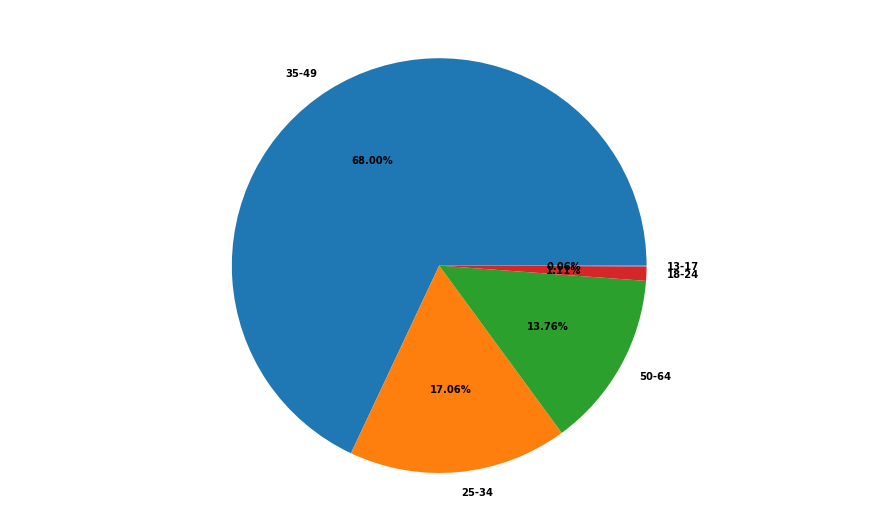

In [93]:
#Display the percentages of each age group in pie charts
age_percentage = ((rev_age_all['Age'].value_counts())/rev_age_all['Age'].value_counts().sum())*100
display(age_percentage)

fig = plt.figure()
ax = fig.add_axes([0, 0, 0.6, 0.6])
ax.axis('equal')
langs = ['35-49', '25-34', '50-64', '18-24', '13-17']
ax.pie(age_percentage, labels = langs, autopct='%1.2f%%')
plt.show()

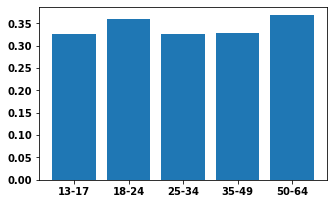

In [94]:
#Calculate the mean polarity of each age group and create a bar chart
rev_age = rev_age_all.drop(rev_age_all.columns.difference(['Polarity', 'Age']), 1)
polarity_per_age = rev_age.groupby(['Age']).mean()['Polarity']

fig = plt.figure()
ax = fig.add_axes([0,0,0.2,0.2])
langs = ['13-17', '18-24', '25-34','35-49','50-64']
ax.bar(langs, polarity_per_age)
plt.show()

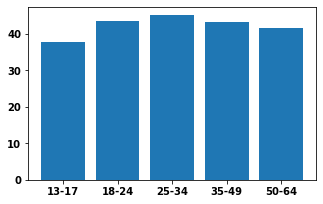

In [95]:
#Calculate the mean score of each age group and create a bar chart
rev_score_age = rev_age_all.drop(rev_age_all.columns.difference(['Score', 'Age']), 1)
score_per_age = rev_score_age.groupby(['Age']).mean()['Score']

fig = plt.figure()
ax = fig.add_axes([0,0,0.2,0.2])
langs = ['13-17', '18-24', '25-34','35-49','50-64']
ax.bar(langs, score_per_age)
plt.show()

<AxesSubplot:title={'center':'Polarity'}, xlabel='Age'>

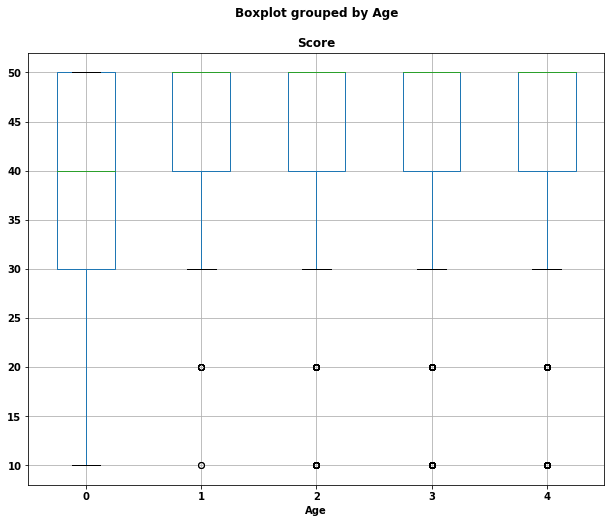

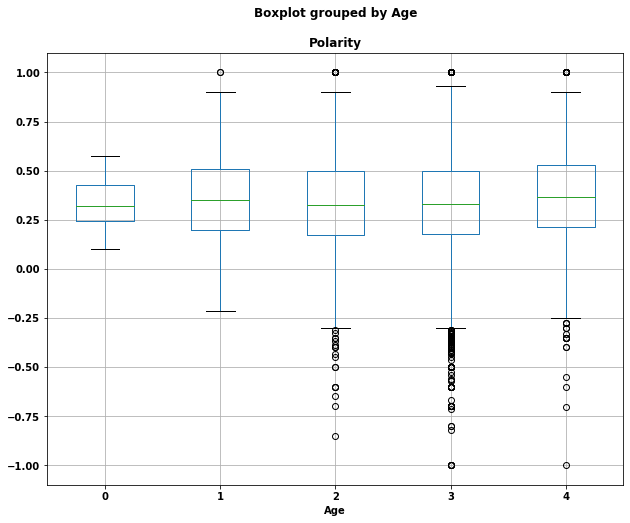

In [96]:
#Create box plots of score and polarity for each gender
rev_score_age.boxplot(column='Score', by='Age', fontsize=10, figsize=(10,8))
rev_age.boxplot(column='Polarity', by='Age', fontsize=10, figsize=(10,8))